In [2]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
#import input_data
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
from backpack.core.layers import Flatten
import pytest
import matplotlib.pyplot as plt
from DirLPA_utils import * 

print("pytorch version: ", torch.__version__)
print("torchvision version: ", torchvision.__version__)
print("cuda available: ", torch.cuda.is_available())

np.random.seed(42)
torch.manual_seed(42)

pytorch version:  1.2.0
torchvision version:  0.4.0a0+6b959ee
cuda available:  True


# Train Cifar10 on Resnet32

In [3]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

In [4]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

def get_alpha_from_Normal_smart(mu, Sigma):
    print("mu: ", mu[12])
    print("Sigma diagonal: ", Sigma[12])
    batch_size, K = mu.size(0), mu.size(1)
    alpha = torch.zeros(batch_size, K)
    sum_exp = torch.exp(-1*mu.cpu()).sum(dim=1)
    for j in range(batch_size):
        for k in range(K):
            alpha[j][k] = 1/Sigma[j][k][k]*(1 - 2/K + torch.exp(mu[j][k])/K**2 * sum_exp[j])
        
    return(torch.Tensor(alpha))

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


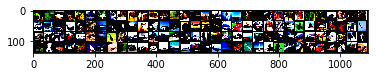

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True,
                                        download=True, transform=transform_train)

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
CIFAR10_train_dataset, CIFAR10_val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_train_dataset, batch_size=BATCH_SIZE_TRAIN_CIFAR10,
                                          shuffle=False)

CIFAR10_val_loader = torch.utils.data.DataLoader(CIFAR10_val_dataset, batch_size=BATCH_SIZE_TRAIN_CIFAR10,
                                          shuffle=False)

CIFAR10_test = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False,
                                       download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_test, batch_size=BATCH_SIZE_TEST_CIFAR10,
                                         shuffle=False)

CIFAR10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [6]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 32

CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_test)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)

CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

train_loader_SVHN = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
test_loader_SVHN = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

Using downloaded and verified file: /home/marius/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/marius/data/SVHN/test_32x32.mat


# Train CIFAR10 on ResNet18

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


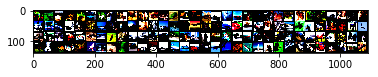

In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def phi(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out
    
    def forward(self, x):
        out = self.phi(x)
        out = self.fc(out)
        return(out)


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CIFAR10_model = ResNet18().to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [13]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [14]:
def test(net, epoch, testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        print("test loss: ", test_loss)
        print("test accuracy: ", correct/total)

In [15]:
def train_all():
    CIFAR10_path = 'weights/cifar10_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR10_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR10_model, epoch, optimizer, trainloader, CIFAR10_path)
            test(CIFAR10_model, epoch, testloader)
            epoch += 1
        lr /= 10

In [15]:
#train_all()

In [16]:
##### if you already have a trained model ##############
CIFAR10_PATH = 'weights/cifar10_resnet18_SGD.pth'
CIFAR10_model = ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, 0, testloader)

loading model from: weights/cifar10_resnet18_SGD.pth
test loss:  18.794341979548335
test accuracy:  0.9502


In [17]:
def Diag_second_order(model, train_loader, var0 = 10, device='cpu'):

    W = list(model.parameters())[-2]
    b = list(model.parameters())[-1]
    m, n = W.shape
    print("n: {} inputs to linear layer with m: {} classes".format(n, m))
    lossfunc = torch.nn.CrossEntropyLoss()

    tau = 1/var0

    extend(lossfunc, debug=False)
    extend(model.fc, debug=False)

    with backpack(DiagHessian()):

        max_len = int(np.ceil(len(train_loader.dataset)/batch_size))
        weights_cov = torch.zeros(max_len, m, n, device=device)
        biases_cov = torch.zeros(max_len, m, device=device)

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.cuda(), y.cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                W_ = W.diag_h
                b_ = b.diag_h

                #add_prior: since it will be flattened later we can just add the prior like that
                W_ += tau * torch.ones(W_.size(), device=device)
                b_ += tau * torch.ones(b_.size(), device=device)


            weights_cov[batch_idx] = W_
            biases_cov[batch_idx] = b_

            print("Batch: {}/{}".format(batch_idx, max_len))

        print(len(weights_cov))
        C_W = torch.mean(weights_cov, dim=0)
        C_b = torch.mean(biases_cov, dim=0)

    # Predictive distribution
    with torch.no_grad():
        M_W_post = W.t()
        M_b_post = b

        C_W_post = C_W
        C_b_post = C_b

    return(M_W_post, M_b_post, C_W_post, C_b_post)

In [23]:
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=CIFAR10_model,
                                                               train_loader=trainloader,
                                                               var0 = 10,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68

In [19]:
M_W_post, M_b_post, U_post, V_post, B_post = KFLP_second_order(model=CIFAR10_model,
                                                               batch_size=128,
                                                               train_loader=trainloader,
                                                               var0 = 10,
                                                               device='cuda')

Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68/391
Batch: 69/391
Batch: 70/391
Batch: 71/391
Ba

In [20]:
def get_in_dist_values(py_in, targets):
    acc_in = np.mean(np.argmax(py_in, 1) == targets)
    #prob_correct = np.choose(targets, py_in.T).mean()
    prob_correct = py_in[targets].mean()
    average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
    MMC = py_in.max(1).mean()
    return(acc_in, prob_correct, average_entropy, MMC)

def get_out_dist_values(py_in, py_out, targets):
    average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
    acc_out = np.mean(np.argmax(py_out, 1) == targets)
    if max(targets) > len(py_in[0]):
        targets = np.array(targets)
        targets[targets >= len(py_in[0])] = 0
    #prob_correct = np.choose(targets, py_out.T).mean()
    prob_correct = py_out[targets].mean()
    labels = np.zeros(len(py_in)+len(py_out), dtype='int32')
    labels[:len(py_in)] = 1
    examples = np.concatenate([py_in.max(1), py_out.max(1)])
    auroc = roc_auc_score(labels, examples)
    MMC = py_out.max(1).mean()
    return(acc_out, prob_correct, average_entropy, MMC, auroc)

In [21]:
@torch.no_grad()
def predict_diagonal_sampling(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, n_samples, verbose=False, cuda=False, timing=False):
    py = []
    max_len = len(test_loader)
    if timing:
        time_sum = 0

    for batch_idx, (x, y) in enumerate(test_loader):

        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        mu, Sigma = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)

        post_pred = MultivariateNormal(mu, Sigma)

        # MC-integral
        t0 = time.process_time()
        py_ = 0

        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1)

        py_ /= n_samples
        py_ = py_.detach()

        py.append(py_)
        t1 = time.process_time()
        if timing:
            time_sum += (t1 - t0)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing: print("time used for sampling with {} samples: {}".format(n_samples, time_sum))
    
    return torch.cat(py, dim=0)

In [22]:
targets_CIFAR10 = testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in test_loader_SVHN:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

# MAP estimate

In [23]:
CIFAR10_test_in_MAP = predict_MAP(CIFAR10_model, testloader, cuda=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_MAP = predict_MAP(CIFAR10_model, CIFAR100_test_loader, cuda=True).cpu().numpy()
CIFAR10_test_out_SVHN_MAP = predict_MAP(CIFAR10_model, test_loader_SVHN, cuda=True).cpu().numpy()

In [24]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR10_test_in_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_SVHN_MAP, targets_SVHN)

In [25]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR10] Accuracy: 0.950; average entropy: 0.066;     MMC: 0.979; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.500;    MMC: 0.825; AUROC: 0.877; Prob @ correct: 0.100
[Out-MAP, KFAC, SVHN] Accuracy: 0.095; Average entropy: 0.658;    MMC: 0.770; AUROC: 0.927; Prob @ correct: 0.100


# Diagonal estimate

In [26]:
CIFAR10_test_in_D = predict_diagonal_sampling(CIFAR10_model, testloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_diagonal_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_diagonal_sampling(CIFAR10_model, test_loader_SVHN, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100, cuda=True, timing=True).cpu().numpy()

time used for sampling with 100 samples: 3.2432679899999357
time used for sampling with 100 samples: 6.800334255000195
time used for sampling with 100 samples: 7.782211134999898


In [27]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR10_test_in_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_SVHN_D, targets_SVHN)

In [28]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR10] Accuracy: 0.951; average entropy: 0.186;     MMC: 0.951; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.008; Average entropy: 0.500;    MMC: 0.722; AUROC: 0.885; Prob @ correct: 0.100
[Out-Diag, KFAC, SVHN] Accuracy: 0.096; Average entropy: 1.007;    MMC: 0.653; AUROC: 0.931; Prob @ correct: 0.100


# Dirichlet Laplace estimate

In [24]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*mu), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    return(alpha)

In [25]:
def get_Gaussian_output_old(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = len(mu_b)
    #print("batch_size, num_classes: ", batch_size, num_classes)
    mu_batch = torch.zeros(batch_size, num_classes)
    sigma_batch = torch.zeros(batch_size, num_classes, num_classes)
    for i in range(batch_size):
        per_class_sigmas = torch.zeros(num_classes)
        for j in range(num_classes):
            #create a diagonal Hessian
            #print(sigma_w[j].size())
            #hess = torch.diag(sigma_w[j])
            #b = x[i] @ hess @ x[i].t()
            #a = sigma_b[i]
            per_class_sigmas[j] = (x[i] * sigma_w[j]) @ x[i].t() + sigma_b[j]

        #print("sizes: ", mu_w.size(), x[i].size(), mu_b.size())
        per_class_mus = x[i] @ mu_w + mu_b
        mu_batch[i] = per_class_mus
        sigma_batch[i] = torch.diag(per_class_sigmas)

    return(mu_batch, sigma_batch)

In [40]:
def get_Gaussian_output(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = mu_b.size(0)
    
    # get mu batch
    mu_w_batch = mu_w.repeat(batch_size, 1, 1)
    mu_b_batch = mu_b.repeat(batch_size, 1)
    mu_batch = torch.bmm(x.view(batch_size, 1, -1), mu_w_batch).view(batch_size, -1) + mu_b_batch
    
    #get sigma batch
    sigma_w_batch = sigma_w.repeat(batch_size, 1, 1)
    sigma_b_batch = sigma_b.repeat(batch_size, 1)
    sigmas_diag = torch.zeros(batch_size, num_classes, device='cuda')
    for j in range(num_classes):
        h1 = x * sigma_w_batch[:, j]
        helper = torch.matmul(h1.view(batch_size, 1, -1), x.view(batch_size, -1, 1))
        helper = helper.view(-1) + sigma_b_batch[:,j]
        sigmas_diag[:,j] = helper
        
    sigma_batch = torch.stack([torch.diag(x) for x in sigmas_diag])

    
    return(mu_batch, sigma_batch)


In [43]:
dataiter = iter(test_loader_SVHN)
x, y = dataiter.next()
x, y = x.cuda(), y.cuda()
x_phi = CIFAR10_model.phi(x).detach()
#print("phi size: ", x_phi.size())
import time
t0 = time.time()
mu_old, Sigma_old = get_Gaussian_output_old(x_phi, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D)
#print("mu, sigma old: ", mu_old.size(), Sigma_old.size())
t1 = time.time()
mu_new, Sigma_new = get_Gaussian_output(x_phi, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D)
t2 = time.time()
print("old: ", t1 - t0)
print("new: ", t2 - t1)
#print("Sigma_old: ", Sigma_old)
#print("Sigma_new: ", Sigma_new)

old:  0.12967133522033691
new:  0.002482891082763672


In [48]:
import time
@torch.no_grad()
#U_post, V_post, B_post
def predict_DIR_LPA(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, verbose=False, cuda=False, timing=False):
    alphas = []
    if timing:
        time_sum = 0

    max_len = int(np.ceil(len(test_loader.dataset)/len(test_loader)))

    for batch_idx, (x, y) in enumerate(test_loader):
        
        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        #mu_pred = phi @ M_W_post + M_b_post
        #mu_pred -= mu_pred.mean(1).view(-1,1)
        #Cov_pred = torch.diag(phi @ U_post @ phi.t()).reshape(-1, 1, 1) * V_post.unsqueeze(0) + B_post.unsqueeze(0)

        mu_pred, Cov_pred = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        
        t0 = time.process_time()
        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        t1 = time.process_time()
        if timing:
            time_sum += (t1-t0)

        alphas.append(alpha)


        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing:
        print("total time used for transform: {:.05f}".format(time_sum))
    
    return(torch.cat(alphas, dim = 0))

In [49]:
CIFAR10_test_in_DIR_LPA = predict_DIR_LPA(CIFAR10_model, testloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_DIR_LPA = predict_DIR_LPA(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_DIR_LPA = predict_DIR_LPA(CIFAR10_model, test_loader_SVHN, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.01509
total time used for transform: 0.03689
total time used for transform: 0.02752


In [50]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR10_test_in_DIR_LPAn = CIFAR10_test_in_DIR_LPA/CIFAR10_test_in_DIR_LPA.sum(1).reshape(-1,1)
CIFAR10_test_out_CIFAR100_DIR_LPAn = CIFAR10_test_out_CIFAR100_DIR_LPA/CIFAR10_test_out_CIFAR100_DIR_LPA.sum(1).reshape(-1,1)
CIFAR10_test_out_SVHN_DIR_LPAn = CIFAR10_test_out_SVHN_DIR_LPA/CIFAR10_test_out_SVHN_DIR_LPA.sum(1).reshape(-1,1)

In [51]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(CIFAR10_test_in_DIR_LPAn, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA = get_out_dist_values(CIFAR10_test_in_DIR_LPAn, CIFAR10_test_out_CIFAR100_DIR_LPAn, targets_CIFAR100)
acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA = get_out_dist_values(CIFAR10_test_in_DIR_LPAn, CIFAR10_test_out_SVHN_DIR_LPAn, targets_SVHN)

In [52]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA, 'CIFAR100', 'DIR_LPA')
print_out_dist_values(acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA, 'SVHN', 'DIR_LPA')

[In, DIR_LPA, CIFAR10] Accuracy: 0.950; average entropy: 0.118;     MMC: 0.970; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.761;    MMC: 0.769; AUROC: 0.863; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, SVHN] Accuracy: 0.095; Average entropy: 1.019;    MMC: 0.690; AUROC: 0.925; Prob @ correct: 0.100


In [53]:
from scipy.special import digamma, loggamma

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))

def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def log_beta_function(alpha):
    return(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha)))

def alphas_entropy(alphas):
    K = len(alphas[0])
    alphas = np.array(alphas)
    entropy = []
    for x in alphas:
        B = log_beta_function(x)
        alpha_0 = np.sum(x)
        C = (alpha_0 - K)*digamma(alpha_0)
        D = np.sum((x-1)*digamma(x))
        entropy.append(B + C - D)
    
    return(np.array(entropy))
        

def alphas_log_prob(alphas):
    alphas = np.array(alphas)
    dig_sum = digamma(alphas.sum(axis=1).reshape(-1,1))
    log_prob = digamma(alphas) - dig_sum
    return(log_prob)

def auroc_entropy(alphas_in, alphas_out):
    
    entropy_in = alphas_entropy(alphas_in)
    entropy_out = alphas_entropy(alphas_out)
    labels = np.zeros(len(entropy_in)+len(entropy_out), dtype='int32')
    labels[:len(entropy_in)] = 1
    examples = np.concatenate([entropy_in, entropy_out])
    auroc_ent = roc_auc_score(labels, examples)
    return(auroc_ent)

def auroc_variance(alphas_in, alphas_out, method='mean'):
    
    if method=='mean':
        variance_in = alphas_variance(alphas_in).mean(1)
        variance_out = alphas_variance(alphas_out).mean(1)
    elif method=='max':
        variance_in = alphas_variance(alphas_in).max(1)
        variance_out = alphas_variance(alphas_out).max(1)
    labels = np.zeros(len(variance_in)+len(variance_out), dtype='int32')
    labels[:len(variance_in)] = 1
    examples = np.concatenate([variance_in, variance_out])
    auroc_ent = roc_auc_score(labels, examples)
    return(auroc_ent)

In [54]:
print("auroc entropy: CIFAR10 in, CIFAR100 out: ", 1-auroc_entropy(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_CIFAR100_DIR_LPA))
print("auroc entropy: CIFAR10 in, SVHN out: ", 1-auroc_entropy(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_SVHN_DIR_LPA))

auroc entropy: CIFAR10 in, CIFAR100 out:  0.8576306
auroc entropy: CIFAR10 in, SVHN out:  0.9294794214812538


In [55]:
print("auroc variance: CIFAR10 in, CIFAR100 out: ", 1-auroc_variance(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_CIFAR100_DIR_LPA, method='mean'))
print("auroc variance: CIFAR10 in, SVHN out: ", 1-auroc_variance(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_SVHN_DIR_LPA, method='mean'))

auroc variance: CIFAR10 in, CIFAR100 out:  0.86443287
auroc variance: CIFAR10 in, SVHN out:  0.9301331707129686


# train on SVHN test on CIFAR10 and CIFAR100

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SVHN_model = ResNet18(num_classes=10).to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [57]:
def train_all_SVHN():
    SVHN_path = 'weights/SVHN_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 25, 25]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(SVHN_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(SVHN_model, epoch, optimizer, train_loader_SVHN, SVHN_path)
            test(SVHN_model, epoch, test_loader_SVHN)
            epoch += 1
        lr /= 10

In [58]:
#train_all_SVHN()

In [59]:
##### if you already have a trained model ##############
SVHN_PATH = 'weights/SVHN_resnet18_SGD.pth'
SVHN_model = ResNet18().to(device)
print("loading model from: {}".format(SVHN_PATH))
SVHN_model.load_state_dict(torch.load(SVHN_PATH))#, map_location=torch.device('cpu')))
#test the model
test(SVHN_model, 0, test_loader_SVHN)

loading model from: weights/SVHN_resnet18_SGD.pth
test loss:  0.2643543668091297
test accuracy:  1.0


In [86]:
M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN = Diag_second_order(model=SVHN_model,
                                                               batch_size=128,
                                                               train_loader=train_loader_SVHN,
                                                               var0 = 10,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/204
Batch: 1/204
Batch: 2/204
Batch: 3/204
Batch: 4/204
Batch: 5/204
Batch: 6/204
Batch: 7/204
Batch: 8/204
Batch: 9/204
Batch: 10/204
Batch: 11/204
Batch: 12/204
Batch: 13/204
Batch: 14/204
Batch: 15/204
Batch: 16/204
Batch: 17/204
Batch: 18/204
Batch: 19/204
Batch: 20/204
Batch: 21/204
Batch: 22/204
Batch: 23/204
Batch: 24/204
Batch: 25/204
Batch: 26/204
Batch: 27/204
Batch: 28/204
Batch: 29/204
Batch: 30/204
Batch: 31/204
Batch: 32/204
Batch: 33/204
Batch: 34/204
Batch: 35/204
Batch: 36/204
Batch: 37/204
Batch: 38/204
Batch: 39/204
Batch: 40/204
Batch: 41/204
Batch: 42/204
Batch: 43/204
Batch: 44/204
Batch: 45/204
Batch: 46/204
Batch: 47/204
Batch: 48/204
Batch: 49/204
Batch: 50/204
Batch: 51/204
Batch: 52/204
Batch: 53/204
Batch: 54/204
Batch: 55/204
Batch: 56/204
Batch: 57/204
Batch: 58/204
Batch: 59/204
Batch: 60/204
Batch: 61/204
Batch: 62/204
Batch: 63/204
Batch: 64/204
Batch: 65/204
Batch: 66/204
Batch: 67/204
Batch: 68

# MAP estimate

In [87]:
SVHN_test_in_MAP = predict_MAP(SVHN_model, test_loader_SVHN, cuda=True).cpu().numpy()
SVHN_test_out_CIFAR10_MAP = predict_MAP(SVHN_model, testloader, cuda=True).cpu().numpy()
SVHN_test_out_CIFAR100_MAP = predict_MAP(SVHN_model, CIFAR100_test_loader, cuda=True).cpu().numpy()

In [88]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(SVHN_test_in_MAP, targets_SVHN)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR10_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100_MAP, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR100_MAP, targets_CIFAR100)

In [89]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'SVHN', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100_MAP, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')

[In, MAP, SVHN] Accuracy: 1.000; average entropy: 0.011;     MMC: 0.999; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.084; Average entropy: 1.161;    MMC: 0.625; AUROC: 0.996; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.012; Average entropy: 1.129;    MMC: 0.637; AUROC: 0.995; Prob @ correct: 0.100


# Diag sampling

In [139]:
SVHN_test_in_D = predict_diagonal_sampling(SVHN_model, test_loader_SVHN, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=100, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_D = predict_diagonal_sampling(SVHN_model, testloader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=100, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_D = predict_diagonal_sampling(SVHN_model, CIFAR100_test_loader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=100, cuda=True, timing=True).cpu().numpy()

time used for sampling with 100 samples: 8.490999598994676
time used for sampling with 100 samples: 3.116778883999359
time used for sampling with 100 samples: 7.373441259999709


In [140]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(SVHN_test_in_D, targets_SVHN)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR10_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR100_D, targets_CIFAR100)

In [141]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'SVHN', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')

[In, Diag, SVHN] Accuracy: 1.000; average entropy: 0.035;     MMC: 0.995; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR10] Accuracy: 0.084; Average entropy: 1.275;    MMC: 0.585; AUROC: 0.995; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.012; Average entropy: 1.244;    MMC: 0.597; AUROC: 0.994; Prob @ correct: 0.100


# Laplace Bridge

In [142]:
SVHN_test_in_DIR_LPA = predict_DIR_LPA(SVHN_model, test_loader_SVHN, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_DIR_LPA = predict_DIR_LPA(SVHN_model, testloader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_DIR_LPA = predict_DIR_LPA(SVHN_model, CIFAR100_test_loader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.03041
total time used for transform: 0.01573
total time used for transform: 0.04067


In [143]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
SVHN_test_in_DIR_LPAn = SVHN_test_in_DIR_LPA/SVHN_test_in_DIR_LPA.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR10_DIR_LPAn = SVHN_test_out_CIFAR10_DIR_LPA/SVHN_test_out_CIFAR10_DIR_LPA.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR100_DIR_LPAn = SVHN_test_out_CIFAR100_DIR_LPA/SVHN_test_out_CIFAR100_DIR_LPA.sum(1).reshape(-1,1)

In [144]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(SVHN_test_in_DIR_LPAn, targets_SVHN)
acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA = get_out_dist_values(SVHN_test_in_DIR_LPAn, SVHN_test_out_CIFAR10_DIR_LPAn, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA = get_out_dist_values(SVHN_test_in_DIR_LPAn, SVHN_test_out_CIFAR100_DIR_LPAn, targets_CIFAR100)

In [145]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'SVHN', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA, 'CIFAR100', 'DIR_LPA')

[In, DIR_LPA, SVHN] Accuracy: 1.000; average entropy: 0.064;     MMC: 0.991; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR10] Accuracy: 0.084; Average entropy: 1.853;    MMC: 0.391; AUROC: 0.996; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR100] Accuracy: 0.012; Average entropy: 1.819;    MMC: 0.405; AUROC: 0.995; Prob @ correct: 0.100


In [146]:
print("auroc variance: SVHN in, CIFAR10 out: ", 1-auroc_variance(alphas_in=SVHN_test_in_DIR_LPA, alphas_out=SVHN_test_out_CIFAR10_DIR_LPA, method='mean'))
print("auroc variance: SVHN in, CIFAR100 out: ", 1-auroc_variance(alphas_in=SVHN_test_in_DIR_LPA, alphas_out=SVHN_test_out_CIFAR100_DIR_LPA, method='mean'))

auroc variance: SVHN in, CIFAR10 out:  0.9959739320835894
auroc variance: SVHN in, CIFAR100 out:  0.994638663952059


# train on CIFAR100 and test on CIFAR10, SVHN

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CIFAR100_model = ResNet18(num_classes=100).to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [100]:
def train_all_CIFAR100():
    CIFAR100_path = 'weights/CIFAR100_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR100_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR100_model, epoch, optimizer, CIFAR100_train_loader, CIFAR100_path)
            test(CIFAR100_model, epoch, CIFAR100_test_loader)
            epoch += 1
        lr /= 10

In [101]:
#train_all_CIFAR100()

In [102]:
##### if you already have a trained model ##############
CIFAR100_PATH = 'weights/CIFAR100_resnet18_SGD.pth'
CIFAR100_model = ResNet18(num_classes=100).to(device)
print("loading model from: {}".format(CIFAR100_PATH))
CIFAR100_model.load_state_dict(torch.load(CIFAR100_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR100_model, 0, CIFAR100_test_loader)

loading model from: weights/CIFAR100_resnet18_SGD.pth
test loss:  573.1084331274033
test accuracy:  0.5921


In [127]:
M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100 = Diag_second_order(model=CIFAR100_model,
                                                               batch_size=128,
                                                               train_loader=CIFAR100_train_loader,
                                                               var0 = 75,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 100 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 6

# MAP estimate for CIFAR100

In [150]:
CIFAR100_test_in_MAP = predict_MAP(CIFAR100_model, CIFAR100_test_loader, cuda=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_MAP = predict_MAP(CIFAR100_model, testloader, cuda=True).cpu().numpy()
CIFAR100_test_out_SVHN_MAP = predict_MAP(CIFAR100_model, test_loader_SVHN, cuda=True).cpu().numpy()

In [151]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR100_test_in_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_CIFAR10_MAP, targets_CIFAR10)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN_MAP, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_SVHN_MAP, targets_SVHN)

In [152]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN_MAP, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR100] Accuracy: 0.592; average entropy: 2.159;     MMC: 0.556; Prob @ correct: 0.010
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.007; Average entropy: 3.419;    MMC: 0.287; AUROC: 0.715; Prob @ correct: 0.010
[Out-MAP, KFAC, SVHN] Accuracy: 0.003; Average entropy: 3.323;    MMC: 0.317; AUROC: 0.687; Prob @ correct: 0.010


# Diag sampling

In [153]:
CIFAR100_test_in_D = predict_diagonal_sampling(CIFAR100_model, CIFAR100_test_loader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=100, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_D = predict_diagonal_sampling(CIFAR100_model, testloader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=100, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_D = predict_diagonal_sampling(CIFAR100_model, test_loader_SVHN, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=100, cuda=True, timing=True).cpu().numpy()

time used for sampling with 100 samples: 21.16798600500624
time used for sampling with 100 samples: 29.07908345600208
time used for sampling with 100 samples: 80.31917256798715


In [154]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR100_test_in_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_CIFAR10_D, targets_CIFAR10)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_SVHN_D, targets_CIFAR100)

/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [155]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR100] Accuracy: 0.591; average entropy: 2.293;     MMC: 0.528; Prob @ correct: 0.010
[Out-Diag, KFAC, CIFAR10] Accuracy: 0.007; Average entropy: 3.507;    MMC: 0.267; AUROC: 0.716; Prob @ correct: 0.010
[Out-Diag, KFAC, SVHN] Accuracy: 0.000; Average entropy: 3.423;    MMC: 0.296; AUROC: 0.686; Prob @ correct: 0.010


# Laplace Bridge

In [156]:
CIFAR100_test_in_DIR_LPA = predict_DIR_LPA(CIFAR100_model, CIFAR100_test_loader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_DIR_LPA = predict_DIR_LPA(CIFAR100_model, testloader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_DIR_LPA = predict_DIR_LPA(CIFAR100_model, test_loader_SVHN, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.05215
total time used for transform: 0.02819
total time used for transform: 0.06157


In [157]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR100_test_in_DIR_LPAn = CIFAR100_test_in_DIR_LPA/CIFAR100_test_in_DIR_LPA.sum(1).reshape(-1,1)
CIFAR100_test_out_CIFAR10_DIR_LPAn = CIFAR100_test_out_CIFAR10_DIR_LPA/CIFAR100_test_out_CIFAR10_DIR_LPA.sum(1).reshape(-1,1)
CIFAR100_test_out_SVHN_DIR_LPAn = CIFAR100_test_out_SVHN_DIR_LPA/CIFAR100_test_out_SVHN_DIR_LPA.sum(1).reshape(-1,1)

In [158]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(CIFAR100_test_in_DIR_LPAn, targets_CIFAR100)
acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA = get_out_dist_values(CIFAR100_test_in_DIR_LPAn, CIFAR100_test_out_CIFAR10_DIR_LPAn, targets_CIFAR10)
acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA = get_out_dist_values(CIFAR100_test_in_DIR_LPAn, CIFAR100_test_out_SVHN_DIR_LPAn, targets_SVHN)

In [159]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'CIFAR100', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA, 'SVHN', 'DIR_LPA')

[In, DIR_LPA, CIFAR100] Accuracy: 0.592; average entropy: 3.581;     MMC: 0.264; Prob @ correct: 0.010
[Out-DIR_LPA, KFAC, CIFAR10] Accuracy: 0.007; Average entropy: 4.420;    MMC: 0.064; AUROC: 0.714; Prob @ correct: 0.010
[Out-DIR_LPA, KFAC, SVHN] Accuracy: 0.003; Average entropy: 4.485;    MMC: 0.052; AUROC: 0.694; Prob @ correct: 0.010


In [160]:
print("auroc variance: CIFAR100 in, CIFAR10 out: ", 1-auroc_variance(alphas_in=CIFAR100_test_in_DIR_LPA, alphas_out=CIFAR100_test_out_CIFAR10_DIR_LPA, method='mean'))
print("auroc variance: CIFAR100 in, SVHN out: ", 1-auroc_variance(alphas_in=CIFAR100_test_in_DIR_LPA, alphas_out=CIFAR100_test_out_SVHN_DIR_LPA, method='mean'))

auroc variance: CIFAR100 in, CIFAR10 out:  0.5013677599999999
auroc variance: CIFAR100 in, SVHN out:  0.5219980812077443


# Do some additional stuff with the Dirichlet

In [40]:
from scipy.special import digamma, loggamma, gamma

def beta_function(x,y):
    return np.exp(loggamma(x) + loggamma(y) - loggamma(x+y))

def get_prob_for_label(alphas):
    
    probs = []
    for alpha in alphas:
        probs_alpha = []
        a_sum = alpha.sum()
        for a_i in alpha:
            b = a_sum - a_i
            probs_alpha.append(beta_function(a_i + 1, b)/ beta_function(a_i, b))
        
        probs.append(probs_alpha)

    return(np.array(probs))


In [41]:
CIFAR10_test_in_DIR_LPA_bp = get_prob_for_label(CIFAR10_test_in_DIR_LPA)
CIFAR10_test_out_CIFAR100_DIR_LPA_bp = get_prob_for_label(CIFAR10_test_out_CIFAR100_DIR_LPA)
CIFAR10_test_out_SVHN_DIR_LPA_bp = get_prob_for_label(CIFAR10_test_out_SVHN_DIR_LPA)

In [42]:
acc_in_DIR_LPA_bp, prob_correct_in_DIR_LPA_bp, ent_in_DIR_LPA_bp, MMC_in_DIR_LPA_bp = get_in_dist_values(CIFAR10_test_in_DIR_LPA_bp, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA_bp, prob_correct_out_CIFAR100_DIR_LPA_bp, ent_out_CIFAR100_DIR_LPA_bp, MMC_out_CIFAR100_DIR_LPA_bp, auroc_out_CIFAR100_DIR_LPA_bp = get_out_dist_values(CIFAR10_test_in_DIR_LPA_bp, CIFAR10_test_out_CIFAR100_DIR_LPA_bp, targets_CIFAR100)
acc_out_SVHN_DIR_LPA_bp, prob_correct_out_SVHN_DIR_LPA_bp, ent_out_SVHN_DIR_LPA_bp, MMC_out_SVHN_DIR_LPA_bp, auroc_out_SVHN_DIR_LPA_bp = get_out_dist_values(CIFAR10_test_in_DIR_LPA_bp, CIFAR10_test_out_SVHN_DIR_LPA_bp, targets_SVHN)

In [43]:
print_in_dist_values(acc_in_DIR_LPA_bp, prob_correct_in_DIR_LPA_bp, ent_in_DIR_LPA_bp, MMC_in_DIR_LPA_bp, 'CIFAR10', 'DIR_LPA_bp')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA_bp, prob_correct_out_CIFAR100_DIR_LPA_bp, ent_out_CIFAR100_DIR_LPA_bp, MMC_out_CIFAR100_DIR_LPA_bp, auroc_out_CIFAR100_DIR_LPA_bp, 'CIFAR100', 'DIR_LPA_bp')
print_out_dist_values(acc_out_SVHN_DIR_LPA_bp, prob_correct_out_SVHN_DIR_LPA_bp, ent_out_SVHN_DIR_LPA_bp, MMC_out_SVHN_DIR_LPA_bp, auroc_out_SVHN_DIR_LPA_bp, 'SVHN', 'DIR_LPA_bp')

[In, DIR_LPA_bp, CIFAR10] Accuracy: 0.951; average entropy: 0.117;     MMC: 0.970; Prob @ correct: 0.938
[Out-DIR_LPA_bp, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.754;    MMC: 0.771; AUROC: 0.861; Prob @ correct: 0.102
[Out-DIR_LPA_bp, KFAC, SVHN] Accuracy: 0.096; Average entropy: 1.002;    MMC: 0.694; AUROC: 0.924; Prob @ correct: 0.098


[-2.18469594e-08 -1.86267720e-08 -3.34365060e-05  1.02327040e-09
 -1.36487681e-08 -3.88689162e-09 -1.33385874e-08 -1.09352875e-08
  4.80208647e-09  4.13208562e-09]
[ 3.86404822e-09  7.48776019e-10 -3.18898743e-07 -2.40361161e-07
 -9.67952088e-08 -6.35357138e-10 -5.05295883e-09  5.57700254e-09
  6.31430431e-10 -5.34713385e-09]
[ 7.82602751e-10  6.88700432e-09 -1.19215514e-08 -1.99047504e-10
  5.95504155e-09  4.29240261e-09 -2.30002270e-07 -1.52487655e-09
 -3.02422204e-09  5.57622720e-10]
[ 2.61167078e-09  2.03815881e-09  1.51459328e-09  1.28349220e-10
  2.56647978e-09 -1.01669769e-09  1.72290608e-08  1.32921579e-09
 -1.15597551e-09  1.55652663e-08]
[ 2.46093658e-08  4.19327973e-09  1.16417463e-08 -6.59244122e-09
  2.12725806e-09 -3.25956416e-09  1.36733752e-08 -2.09692939e-09
 -5.23858971e-06  2.11036047e-08]
[ 7.36535608e-09 -3.79182003e-09 -3.66812433e-09 -6.51413794e-09
 -2.84850476e-08 -4.46306844e-09 -5.85039672e-09 -9.49064730e-10
 -5.12953966e-09 -2.86946330e-09]
[-8.52558673e-10

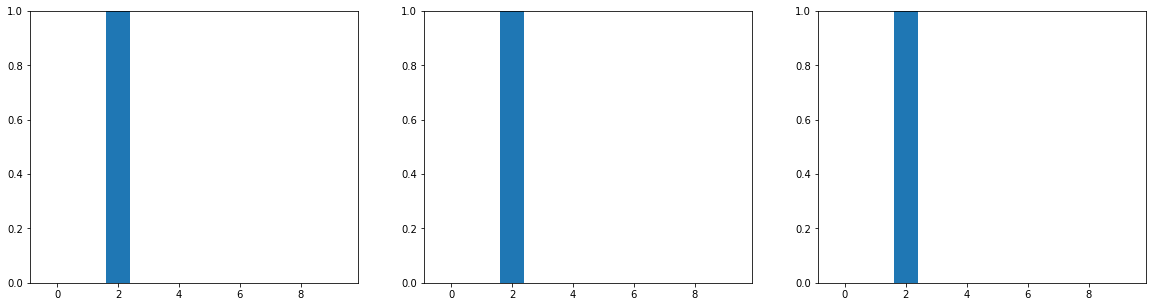

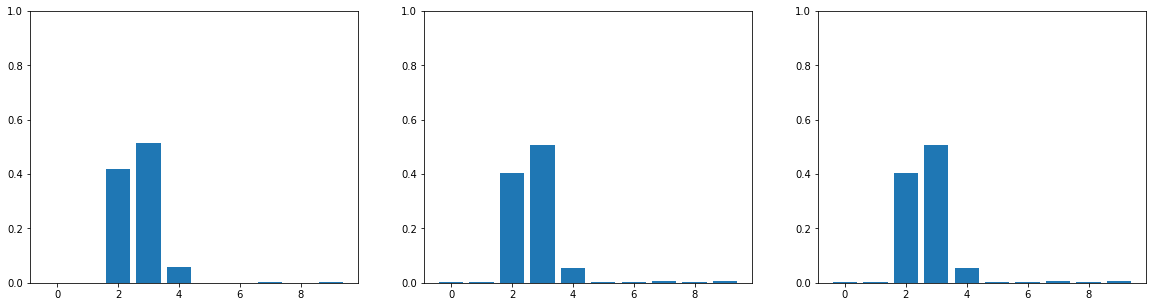

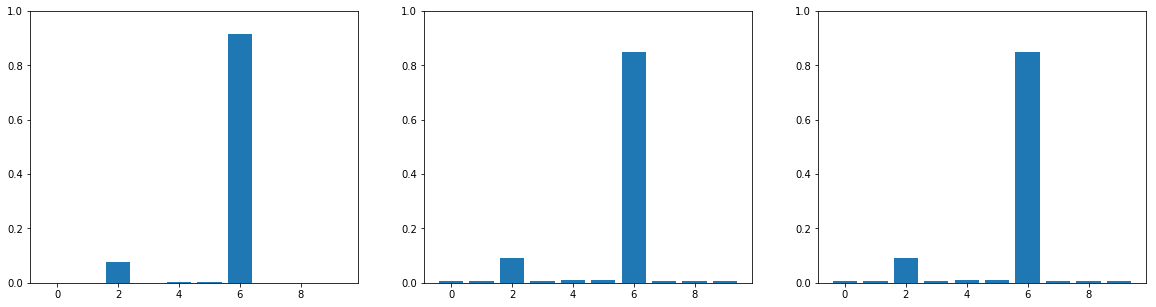

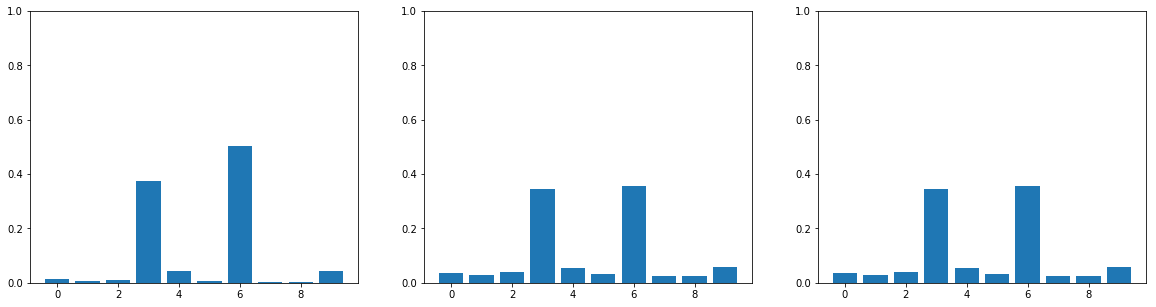

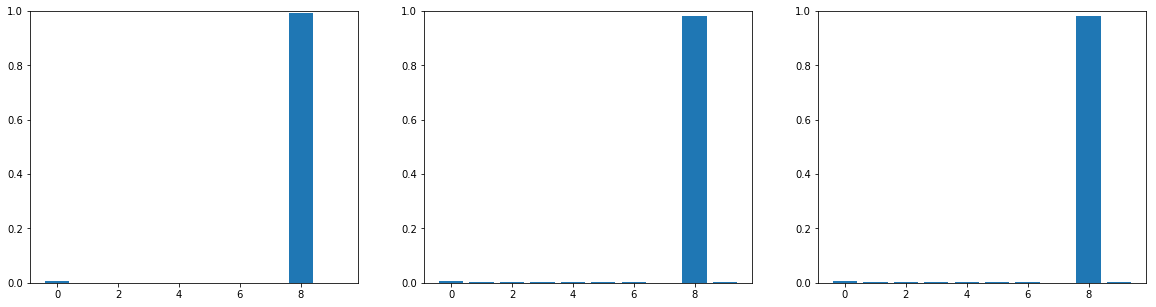

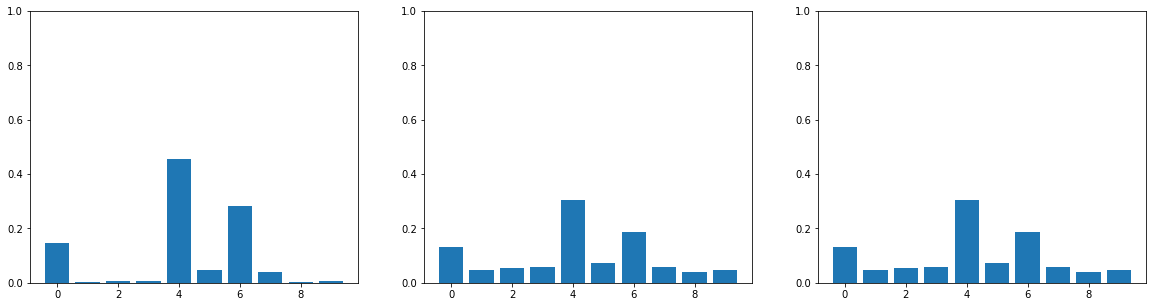

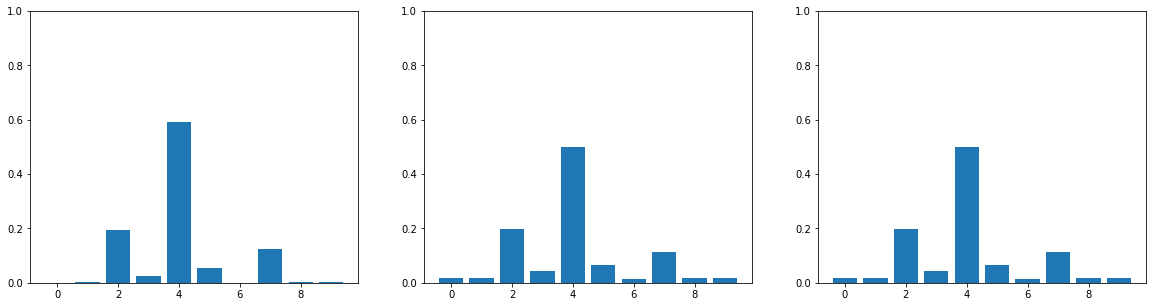

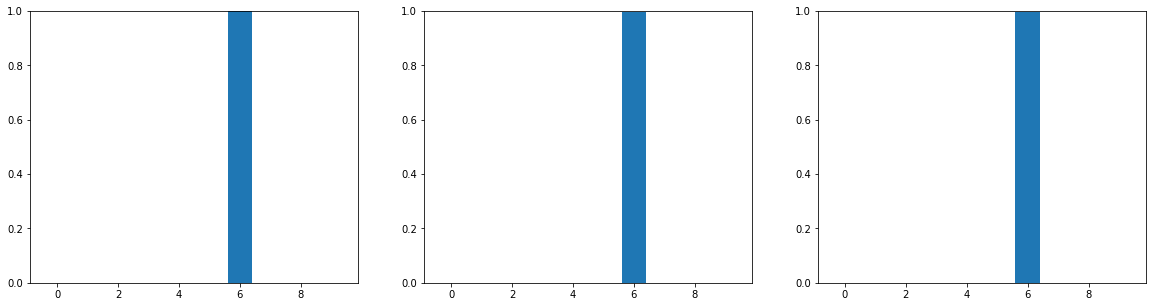

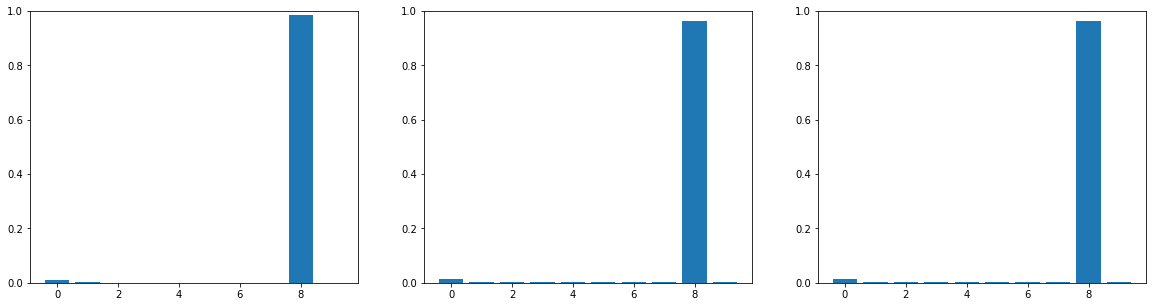

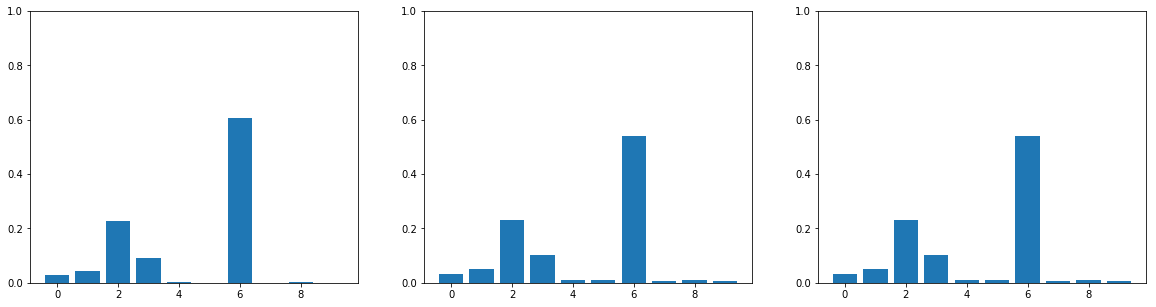

In [45]:
for idx in range(10):
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(20, 5))
    x = CIFAR10_test_out_CIFAR100_D[idx]
    x_d = CIFAR10_test_out_CIFAR100_DIR_LPAn[idx]
    x_db = CIFAR10_test_out_CIFAR100_DIR_LPA_bp[idx]
    
    print(x_d-x_db)
    axs[0].bar(range(10), x)
    axs[0].set_ylim(0,1)
    
    axs[1].bar(range(10), x_d)
    axs[1].set_ylim(0,1)
    
    axs[2].bar(range(10), x_db)
    axs[2].set_ylim(0,1)
    